In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
price_df = pd.read_hdf('../data/binance_BTC_USDT_new.h5')
price_df.sort_index(inplace=True)
price_df = price_df[~price_df.index.duplicated(keep='first')]
price_df = price_df.reindex(np.arange(price_df.index[0], price_df.index[-1] + 1, 60))
price_df['price'] = price_df['price'].ffill()
price_df['amount'] = price_df['amount'].fillna(value=0)
vwap_df = pd.read_hdf('../data/binance_BTC_USDT_vwap.h5')

In [23]:
print(pd.to_datetime(price_df.index[0], unit='s'))
print(pd.to_datetime(price_df.index[-1], unit='s'))
print(vwap_df.index[0])
print(vwap_df.index[-1])

2017-08-17 04:01:00
2023-11-19 15:04:00
2017-08-17 04:01:00
2023-11-30 15:14:00


# Train data

In [25]:
train_df = price_df.loc[int(pd.to_datetime('2017-08-18').timestamp()):int(pd.to_datetime('2023-06-01').timestamp())]
train_df.to_hdf('../data/train_data.h5', key='data', format='table')

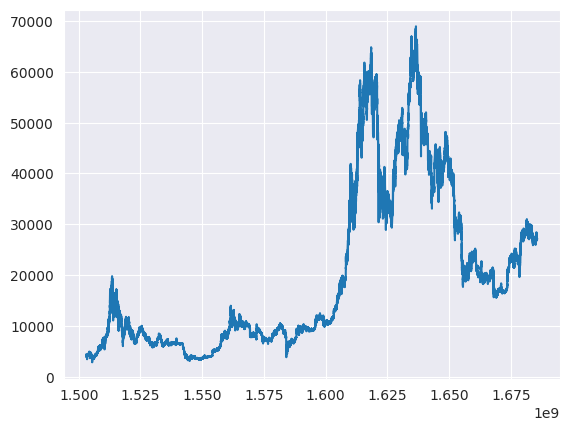

In [26]:
plt.plot(train_df['price'])

# Evaluation data

In [27]:
start_time = pd.to_datetime('2023-06-01') + pd.Timedelta(minutes=1)
start_ts = int(start_time.timestamp())

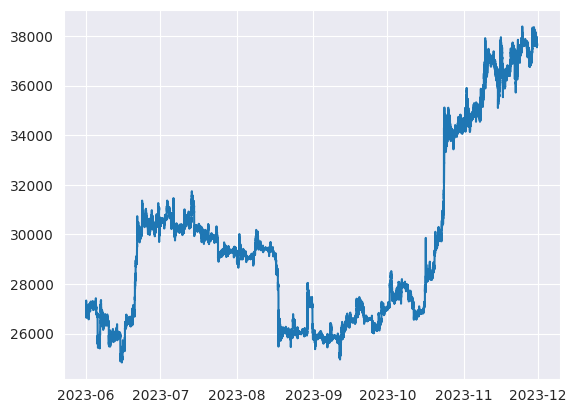

In [31]:
plt.plot(vwap_df.loc[start_time:]['price'])

### 2023-06 - 2023-07
Slowly falling then large pump

In [34]:
start_time = pd.to_datetime('2023-06-01') + pd.Timedelta(minutes=1)
start_ts = int(start_time.timestamp())
end_time = pd.to_datetime('2023-07-01') + pd.Timedelta(minutes=1)
end_ts = int(end_time.timestamp())

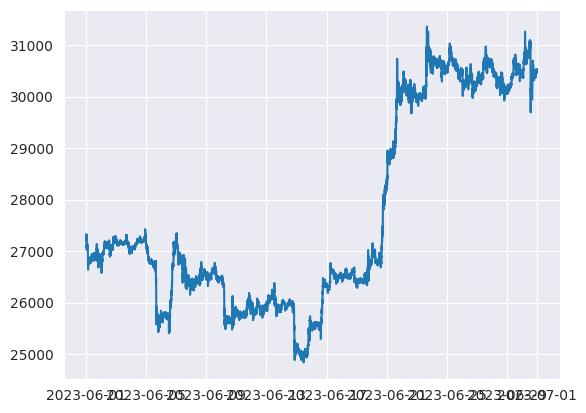

In [35]:
plt.plot(vwap_df.loc[start_time:end_time]['price'])

In [36]:
eval_data = price_df.loc[:end_ts]
eval_data.to_hdf('../data/eval_data_june.h5', key='data')

### 2023-07 - 2023-08
Slowly falling

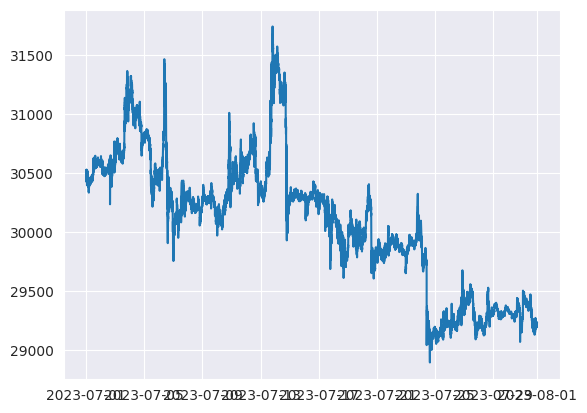

In [37]:
start_time = pd.to_datetime('2023-07-01') + pd.Timedelta(minutes=1)
start_ts = int(start_time.timestamp())
end_time = pd.to_datetime('2023-08-01') + pd.Timedelta(minutes=1)
end_ts = int(end_time.timestamp())

plt.plot(vwap_df.loc[start_time:end_time]['price'])

eval_data = price_df.loc[:end_ts]
eval_data.to_hdf('../data/eval_data_july.h5', key='data')

### 2023-08 - 2023-09
Huge drop

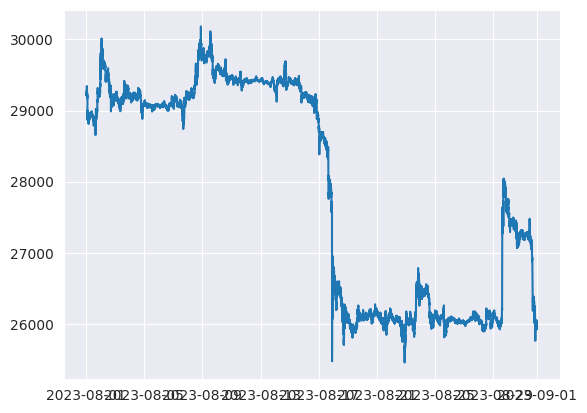

In [38]:
start_time = pd.to_datetime('2023-08-01') + pd.Timedelta(minutes=1)
start_ts = int(start_time.timestamp())
end_time = pd.to_datetime('2023-09-01') + pd.Timedelta(minutes=1)
end_ts = int(end_time.timestamp())

plt.plot(vwap_df.loc[start_time:end_time]['price'])

eval_data = price_df.loc[:end_ts]
eval_data.to_hdf('../data/eval_data_august.h5', key='data')

### 2023-09 - 2023-10
Slowly growing

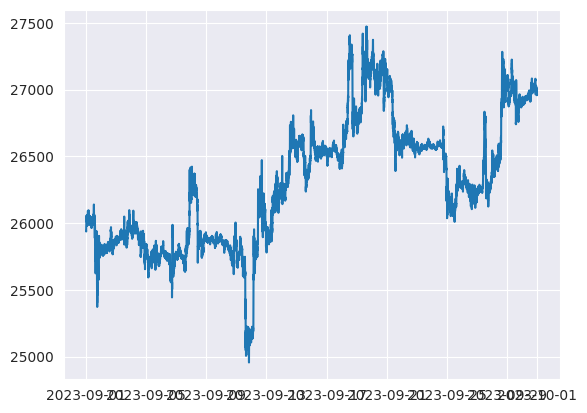

In [39]:
start_time = pd.to_datetime('2023-09-01') + pd.Timedelta(minutes=1)
start_ts = int(start_time.timestamp())
end_time = pd.to_datetime('2023-10-01') + pd.Timedelta(minutes=1)
end_ts = int(end_time.timestamp())

plt.plot(vwap_df.loc[start_time:end_time]['price'])

eval_data = price_df.loc[:end_ts]
eval_data.to_hdf('../data/eval_data_september.h5', key='data')

### 2023-10 - 2023-11
Huge pump

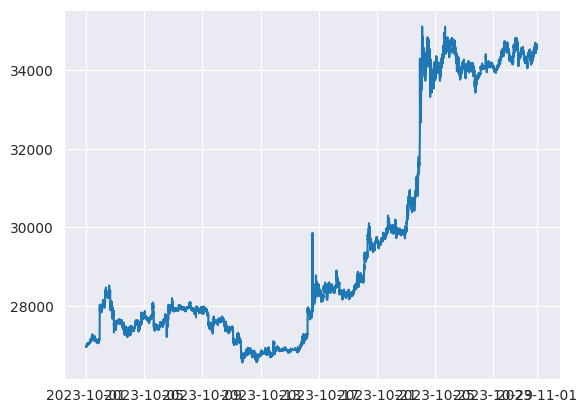

In [40]:
start_time = pd.to_datetime('2023-10-01') + pd.Timedelta(minutes=1)
start_ts = int(start_time.timestamp())
end_time = pd.to_datetime('2023-11-01') + pd.Timedelta(minutes=1)
end_ts = int(end_time.timestamp())

plt.plot(vwap_df.loc[start_time:end_time]['price'])

eval_data = price_df.loc[:end_ts]
eval_data.to_hdf('../data/eval_data_october.h5', key='data')

# Generate RL predictions

In [3]:
%env PYTHONWARNINGS=ignore::DeprecationWarning
import warnings
import logging

import os

# Set environment variable to ignore DeprecationWarnings
os.environ['PYTHONWARNINGS'] = "ignore::DeprecationWarning"

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")

import ray
import rl_trading.simulation
import importlib
import numpy as np
import pandas as pd
from tqdm import tqdm
from rl_trading.utils import load_model
from rl_trading.simulation.env import BacktestingEnv, StateConfig, ExchangeConfig, SimulationConfig, StockExchangeEnv0
from rl_trading.data.provider import MarketDataProvider

eval_months = ['june', 'july', 'august', 'september', 'october']

outer_pbar = tqdm(eval_months, desc='Generating predictions')
for month in outer_pbar:
    outer_pbar.set_description(f'Evaluating month: {month}')
    ray.shutdown()
    ray.init(logging_level=logging.ERROR)
    importlib.reload(rl_trading.simulation)
    historical_data_file_path = f'../data/eval_data_{month}.h5'
    
    model = load_model('/home/fassty/Devel/school/diploma_thesis/code/exp_results/short_episodes_future/discrete_env_15ind_normalized/ApexDQN_0_2023-12-05_18-10-22/checkpoint_000199')
    state_config = model.config.env_config['state_config']
    exchange_config = model.config.env_config['exchange_config']
    sim_config = model.config.env_config['sim_config']
    MarketDataProvider._instances = {}
    env = StockExchangeEnv0(historical_data_file_path, sim_config=sim_config, exchange_config=exchange_config, state_config=state_config, stage='eval', eval_period=30 * 1440)

    obs, done = env.reset()[0], False
    state = [np.zeros([256], np.float32) for _ in range(2)]
    prev_action = 0
    prev_reward = 0
    
    action_history = pd.DataFrame(columns=['action'])
    for i in range(30 * 1440 + 1):
        idx = env.current_idx
        timestamp = env.market_data['1min'].index[idx]
        prev_action = model.compute_single_action(observation=obs)
        # prev_action, state, _ = model.compute_single_action(observation=obs, state=state, prev_action=prev_action, prev_reward=prev_reward)
        obs, prev_reward, terminated, truncated, _ = env.step(prev_action)
        done = terminated or truncated
        action_history.loc[timestamp] = prev_action
        if done:
            break

    action_history.to_csv(f'../data/rl_preds_{month}.csv')

env: PYTHONWARNINGS=ignore::DeprecationWarning


Evaluating month: june:   0%|          | 0/5 [00:00<?, ?it/s]2023-12-07 22:43:15,414	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/apex_dqn/` has been deprecated. Use `rllib_contrib/apex_dqn/` instead. This will raise an error in the future!
(RolloutWorker pid=4051190) 2023-12-07 22:43:18,246	WARNING __init__.py:10 -- PG has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependencies for e.g. ray[rllib] and other packages! See https://github.com/ray-project/ray/tree/master/rllib_contrib#rllib-contrib for more information on the RLlib contrib effort.
(RolloutWorker pid=4051190) 2023-12-07 22:43:18,256	WARNING __init__.py:10 -- ApexDQN has/have been moved to `rllib_contrib` and will no longer be maintained by the 